In [219]:
import pandas as pd
import numpy as np
import math
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
%matplotlib inline

In [220]:
test_df = pd.read_csv('dataset/test_cleaned.csv', sep='|')

In [231]:
def fill_na(df):
    pid = 1
    last_temp = 36.3
    for i in range(df.shape[0]):
        if df.iloc[i].patient_id == pid:
            if math.isnan(df.iloc[i].Temp):
                df.at[i, 'Temp'] = last_temp
            else:
                last_temp = df.iloc[i].Temp
            
        else:
            pid = df.iloc[i].patient_id
            last_temp = 37
            if math.isnan(df.iloc[i].Temp):
                df.at[i, 'Temp'] = last_temp
            else:
                last_temp = df.iloc[i].Temp
                
        # fill hr
        if math.isnan(df.iloc[i].HR):
            for j in range(i+1, df.shape[0]):
                if df.iloc[j].patient_id == df.iloc[i].patient_id:
                    if math.isnan(df.iloc[j].HR) == False:
                        df.at[i, 'HR'] = df.iloc[j].HR
                        break
                else:
                    df.at[i, 'HR'] = df.iloc[i-1].HR
                    break
                    
        # fill sbp
        if math.isnan(df.iloc[i].SBP):
            for j in range(i+1, df.shape[0]):
                if df.iloc[j].patient_id == df.iloc[i].patient_id:
                    if math.isnan(df.iloc[j].SBP) == False:
                        df.at[i, 'SBP'] = df.iloc[j].SBP
                        break
                else:
                    df.at[i, 'SBP'] = df.iloc[i-1].SBP
                    break
                    
        # fill Resp
        if math.isnan(df.iloc[i].Resp):
            for j in range(i+1, df.shape[0]):
                if df.iloc[j].patient_id == df.iloc[i].patient_id:
                    if math.isnan(df.iloc[j].Resp) == False:
                        df.at[i, 'Resp'] = df.iloc[j].Resp
                        break
                else:
                    df.at[i, 'Resp'] = df.iloc[i-1].Resp
                    break
        # fill O2Sat
        if math.isnan(df.iloc[i].O2Sat):
            for j in range(i+1, df.shape[0]):
                if df.iloc[j].patient_id == df.iloc[i].patient_id:
                    if math.isnan(df.iloc[j].O2Sat) == False:
                        df.at[i, 'O2Sat'] = df.iloc[j].O2Sat
                        break
                else:
                    df.at[i, 'O2Sat'] = df.iloc[i-1].O2Sat
                    break
                    
        # fill MAP
        if math.isnan(df.iloc[i].MAP):
            for j in range(i+1, df.shape[0]):
                if df.iloc[j].patient_id == df.iloc[i].patient_id:
                    if math.isnan(df.iloc[j].MAP) == False:
                        df.at[i, 'MAP'] = df.iloc[j].MAP
                        break
                else:
                    df.at[i, 'MAP'] = df.iloc[i-1].MAP
                    break
                    
    return df.fillna(-999)

def get_hr_label(df):
    df.loc[df.HR > 90, 'hr_label'] = 1
    df.loc[df.HR <= 90, 'hr_label'] = 0
    
    return df

def get_age_label(df):
    df.loc[df.Age >= 80, 'age_label'] = 1 # old
    df.loc[(df.Age >= 18) & (df.Age < 80), 'age_label'] = 0 # adult
    
    return df

def get_temp_label(df):
    df.loc[(df.Temp >= 38) | (df.Temp <= 36), 'temp_label'] = 0
    df.loc[(df.Temp < 38) & (df.Temp > 36), 'temp_label'] = 1
    
    return df

def get_resp_label(df):
    # normal
    df.loc[(df.Resp.between(30, 60)) & (df.Age <= 1), 'resp_label'] = '0'
    df.loc[(df.Resp.between(24, 40)) & (df.Age.between(2, 3)), 'resp_label'] = '0'
    df.loc[(df.Resp.between(22, 34)) & (df.Age.between(4, 6)), 'resp_label'] = '0'
    df.loc[(df.Resp.between(18, 30)) & (df.Age.between(7, 12)), 'resp_label'] = '0'
    df.loc[(df.Resp.between(12, 16)) & (df.Age.between(13, 17)), 'resp_label'] = '0'
    df.loc[(df.Resp.between(12, 20)) & (df.Age >= 18), 'resp_label'] = '0'
    
    # abnormal
    df.loc[((df.Resp < 30) | (df.Resp > 60)) & (df.Age <= 1), 'resp_label'] = '1'
    df.loc[((df.Resp < 24) | (df.Resp > 40)) & (df.Age.between(2, 3)), 'resp_label'] = '1'
    df.loc[((df.Resp < 22) | (df.Resp > 34)) & (df.Age.between(4, 6)), 'resp_label'] = '1'
    df.loc[((df.Resp < 18) | (df.Resp > 30)) & (df.Age.between(7, 12)), 'resp_label'] = '1'
    df.loc[((df.Resp < 12) | (df.Resp > 16)) & (df.Age.between(13, 17)), 'resp_label'] = '1'
    df.loc[((df.Resp < 12) | (df.Resp > 20)) & (df.Age >= 18), 'resp_label'] = '1'
    
    return df

def get_sbp_label(df):
    df.loc[df.SBP <= 100, 'sbp_label'] = 1
    df.loc[df.SBP > 100, 'sbp_label'] = 0
    
    return df

def get_paco2_label(df):
    df.loc[df.PaCO2 < 32, 'paco2_label'] = 1
    df.loc[df.PaCO2 >= 32, 'paco2_label'] = 0
    
    return df

def get_map_label(df):
    df.loc[df.MAP.between(70, 100), 'map_label'] = 0
    df.loc[(df.MAP > 100) | (df.MAP < 70), 'map_label'] = 1
    
    return df



In [222]:
test_df = fill_na(test_df)

In [232]:
test_df = get_age_label(test_df)
test_df = get_hr_label(test_df)
test_df = get_temp_label(test_df)
test_df = get_resp_label(test_df)
test_df = get_paco2_label(test_df)
test_df = get_sbp_label(test_df)
test_df = get_map_label(test_df)

In [224]:
test_df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,HospAdmTime,ICULOS,SepsisLabel,patient_id,age_label,hr_label,temp_label,resp_label,paco2_label,sbp_label
0,65.0,95.5,36.30,113.00,84.0,-999.0,16.0,-999.0,-999.0,-999.0,...,-0.01,1,0,1,0.0,0.0,1.0,0,1.0,0.0
1,65.0,95.5,36.30,113.00,84.0,66.5,16.0,0.0,32.0,-999.0,...,-0.01,2,0,1,0.0,0.0,1.0,0,0.0,0.0
2,62.5,98.0,38.00,105.25,64.0,64.5,17.5,-999.0,-999.0,0.5,...,-0.01,3,0,1,0.0,0.0,0.0,0,1.0,0.0
3,62.5,100.0,38.00,116.50,82.0,62.0,18.0,-999.0,-999.0,-999.0,...,-0.01,4,0,1,0.0,0.0,0.0,0,1.0,0.0
4,63.0,100.0,38.00,95.00,70.0,56.0,18.0,-999.0,-999.0,-999.0,...,-0.01,5,0,1,0.0,0.0,0.0,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120202,70.0,96.0,36.44,137.00,82.0,58.0,13.0,-999.0,-999.0,-999.0,...,-5.71,18,0,3050,0.0,0.0,1.0,0,1.0,0.0
120203,78.0,98.0,36.44,134.00,86.0,60.0,14.0,-999.0,-999.0,-999.0,...,-5.71,19,0,3050,0.0,0.0,1.0,0,1.0,0.0
120204,91.0,96.0,36.72,129.00,79.0,56.0,18.0,-999.0,-999.0,-999.0,...,-5.71,20,0,3050,0.0,1.0,1.0,0,1.0,0.0
120205,91.0,94.0,36.72,150.00,73.0,62.0,7.0,-999.0,-999.0,-999.0,...,-5.71,21,0,3050,0.0,1.0,1.0,1,1.0,0.0


In [225]:
class TestKit(object):
    def __init__(self, classifier, df):
        self.df = df
        self.clf = classifier
        self.y_test = []
        self.y_pred = []
        self.test(df)
        
        
    def test(self, df):
        patient_num = df.patient_id.max()
        for i in range(patient_num):
            pid = i + 1
            test = df[df.patient_id == pid]
            test.reset_index(inplace=True)
            
            X = test.drop(columns=['index', 'patient_id', 'SepsisLabel'])
            # print(X.columns)
            y = test.SepsisLabel.tolist()
            
            # predict
            y_pred = self.clf.predict(X)
            
            if 1 in y:
                self.y_test.append(1)
                index = y.index(1)
                if y_pred[index] == 1:
                    self.y_pred.append(1)
                else:
                    self.y_pred.append(0)
            else:
                self.y_test.append(0)
                if 1 in y_pred:
                    self.y_pred.append(1)
                else:
                    self.y_pred.append(0)
    
    
    def score(self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        acurate_rate = (tp + tn) / (tp + tn + fp + fn)
        return acurate_rate
    
    def heatmap(self):
        cfm = confusion_matrix(self.y_test, self.y_pred)
        tn, fp, fn, tp = cfm.ravel()
        tnr = tn / (tn + fp)
        fpr = fp / (tn + fp)
        fnr = fn / (fn + tp)
        tpr = tp / (fn + tp)
        new_cfm = [[tnr, fpr], [fnr, tpr]]
        fig = sns.heatmap(new_cfm, annot=True, cmap='Blues', fmt='.2%')
        return fig
                        
            
            

In [234]:
# load model
with open('BRFC.pkl', 'rb') as file:
    clf = pkl.load(file)

In [235]:
tk = TestKit(clf, test_df)
tk.score()

0.5754098360655737

<AxesSubplot:>

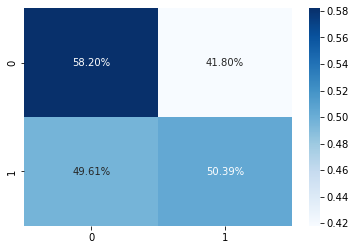

In [236]:
tk.heatmap()